<a href="https://colab.research.google.com/github/JohannesKarwou/notebooks/blob/main/freeSolvSummary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install sketch

In [2]:
import sketch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
sns.set_theme(style='white', rc={'figure.figsize': (12,12),'axes.unicode_minus': False,'axes.labelsize': 30.0, 'font.size': 65, 'legend.fontsize': 25, 'lines.markersize': 20,'xtick.labelsize': 30,'ytick.labelsize': 30, 'xtick.bottom': True, 'xtick.direction': 'in', 'ytick.left': True, 'ytick.direction': 'in',})

In [4]:
try:
    data = pd.read_csv("https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/finalOverview.csv?token=GHSAT0AAAAAAB5HV5NPL3VEMAQNOWDH34SCY74YMFQ")
except:
    data = pd.read_csv("data/finalOverview.csv")

In [5]:
def plotting_grey_area(i, one_plot = False):
    # shaded grey area   
    if one_plot:
      x = np.linspace(-30,20,5)
      y = x
      axs.plot(x, y, alpha = 0.9, color = 'C7',linestyle='dashed')
      y2 = x +1
      axs.plot(x, y2, alpha = 0.3, color = 'C7',linestyle='dashed')
      y3 = x -1 
      axs.plot(x, y3, alpha = 0.3, color = 'C7',linestyle='dashed')
      axs.fill_between(x,y2,y3, alpha = 0.3, color = 'Grey')

      x = np.linspace(-30,20,5)
      y = x
      axs.plot(x, y, alpha = 0.9, color = 'C7',linestyle='dashed')
      y2 = x +2
      axs.plot(x, y2, alpha = 0.3, color = 'C7',linestyle='dashed')
      y3 = x -2 
      axs.plot(x, y3, alpha = 0.3, color = 'C7',linestyle='dashed')
      axs.fill_between(x,y2,y3, alpha = 0.3, color = 'Grey')
    else:
      x = np.linspace(-30,20,5)
      y = x
      axs[i].plot(x, y, alpha = 0.9, color = 'C7',linestyle='dashed')
      y2 = x +1
      axs[i].plot(x, y2, alpha = 0.3, color = 'C7',linestyle='dashed')
      y3 = x -1 
      axs[i].plot(x, y3, alpha = 0.3, color = 'C7',linestyle='dashed')
      axs[i].fill_between(x,y2,y3, alpha = 0.3, color = 'Grey')

      x = np.linspace(-30,20,5)
      y = x
      axs[i].plot(x, y, alpha = 0.9, color = 'C7',linestyle='dashed')
      y2 = x +2
      axs[i].plot(x, y2, alpha = 0.3, color = 'C7',linestyle='dashed')
      y3 = x -2 
      axs[i].plot(x, y3, alpha = 0.3, color = 'C7',linestyle='dashed')
      axs[i].fill_between(x,y2,y3, alpha = 0.3, color = 'Grey')

In [6]:
def bootstrap_metric(fct, x_values, y_values, p_value = False):
    bootstrapped_metric = []
    # bootstrap metric to generate test distribution
    for _ in range(1000):
        indices = np.random.choice(range(0, len(x_values)), size=len(x_values), replace=True)
        x_selection = np.take(x_values, indices)
        y_selection = np.take(y_values, indices)
        if p_value:
          r = fct(x_selection, y_selection)[0]
        else:
          r = fct(x_selection, y_selection)
        bootstrapped_metric.append(r)    

    # define 90% CI
    alpha = 10.0
    lower_p = alpha / 2.0
    # get value at or near percentile (take a look at the definition of percentile if 
    # you have less than 100 values to make sure you understand what is happening)
    lower = np.percentile(bootstrapped_metric, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = np.percentile(bootstrapped_metric, upper_p)
    # calculate true mean
    if p_value:
      mean = fct(x_values, y_values)[0]
    else:
      mean = fct(x_values, y_values)
    return mean, lower, upper


def calculate_statistics(x_values, y_values):
  # bootstrap RMSE
  def calc_rmse(x_values, y_values):
      return np.sqrt(mean_squared_error(x_values, y_values))
  rmse_mean, rmse_lower, rmse_upper = bootstrap_metric(calc_rmse, x_values, y_values)
  print(f'RMSE:  {round(rmse_mean, 2)} [{round(rmse_lower,2)}, {round(rmse_upper,2)}]')

  # bootstrap MAE
  mae_mean, mae_lower, mae_upper = bootstrap_metric(mean_absolute_error, x_values, y_values)
  print(f'MAE:  {round(mae_mean, 2)} [{round(mae_lower,2)}, {round(mae_upper,2)}]')

  # bootstrap Pearson
  pearson_mean, pearson_lower, pearson_upper = bootstrap_metric(scipy.stats.pearsonr, x_values, y_values, p_value = True)
  print(f"Pearson correlation:  {round(pearson_mean, 2)} [{round(pearson_lower,2)}, {round(pearson_upper,2)}]")

  # bootstrap Spearman
  spearman_mean, spearman_lower, spearman_upper = bootstrap_metric(scipy.stats.spearmanr, x_values, y_values, p_value = True)
  print(f"Spearman's correlation:  {round(spearman_mean, 2)} [{round(spearman_lower,2)}, {round(spearman_upper,2)}]")

  # bootstrap Kendalltau
  kendall_mean, kendall_lower, kendall_upper = bootstrap_metric(scipy.stats.kendalltau, x_values, y_values, p_value = True)
  print(f"Kendalltau: {round(kendall_mean, 2)} [{round(kendall_lower,2)}, {round(kendall_upper,2)}]")

  return round(rmse_mean,2), round(mae_mean,2), round(pearson_mean,2), round(spearman_mean,2), round(kendall_mean,2)

In [7]:
data = data.dropna(subset=["dG (TF)"])

In [8]:
print(f"### Statistics for CGenFF ###")
calculate_statistics(data[" experimental value (kcal/mol)"],data["dG (TF)"])
print(f"### Statistics for GAFF ###")
calculate_statistics(data[" experimental value (kcal/mol)"],data[" Mobley group calculated value (GAFF) (kcal/mol)"])

### Statistics for CGenFF ###
RMSE:  1.88 [1.69, 2.09]
MAE:  1.31 [1.22, 1.39]
Pearson correlation:  0.9 [0.88, 0.92]
Spearman's correlation:  0.91 [0.89, 0.93]
Kendalltau: 0.77 [0.74, 0.79]
### Statistics for GAFF ###
RMSE:  1.43 [1.32, 1.52]
MAE:  1.07 [1.01, 1.14]
Pearson correlation:  0.94 [0.93, 0.95]
Spearman's correlation:  0.94 [0.93, 0.95]
Kendalltau: 0.8 [0.78, 0.82]


(1.43, 1.07, 0.94, 0.94, 0.8)

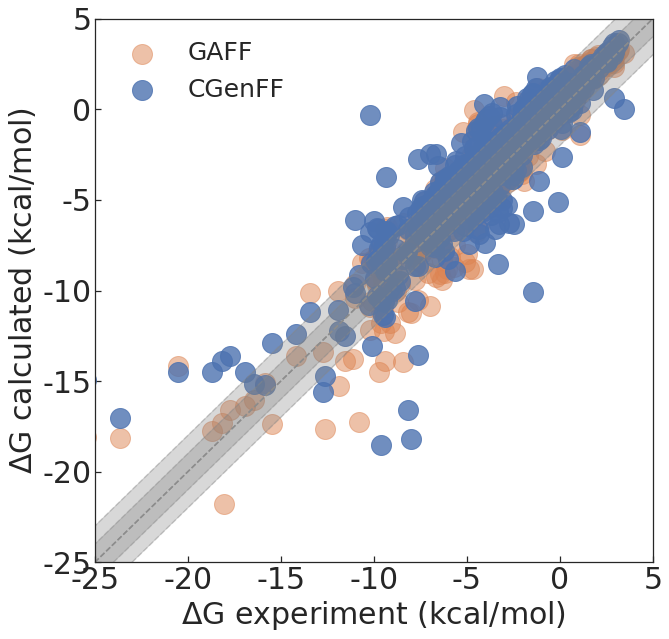

In [9]:
fig, axs = plt.subplots(1,1, figsize=(10, 10))

x = data[" experimental value (kcal/mol)"]
mobley = data[" Mobley group calculated value (GAFF) (kcal/mol)"]
tf = data["dG (TF)"]
axs.scatter(x,mobley, label = "GAFF", alpha = 0.5 ,color ="C1")
axs.scatter(x,tf, label = "CGenFF", alpha = 0.8, color = "C0")

plotting_grey_area(0, one_plot=True)
axs.set_xlim([-25,5])
axs.set_ylim([-25,5])
axs.set_xlabel("$\Delta$G experiment (kcal/mol)")
axs.set_ylabel("$\Delta$G calculated (kcal/mol)")  
plt.legend(frameon=False)

# text = f'RMSE: {calculate_statistics(x,tf)[0]} \n MAE: {calculate_statistics(x,tf)[1]} \n R: {calculate_statistics(x,tf)[2]} \n Spearman: {calculate_statistics(x,tf)[2]} \n'
# axs.text(-1.5,-21, text , fontsize=20, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'w', 'ec': 'C1', 'alpha': 0.9})


In [10]:
data_reduced = data.dropna(subset=["dG (Brooks)"])
print(len(data_reduced))

204


In [11]:
print(f"##### Statistics for TF vs experiment #####")
calculate_statistics(data_reduced[" experimental value (kcal/mol)"],data_reduced["dG (TF)"])
print(f"##### Statistics for Brooks vs experiment #####")
calculate_statistics(data_reduced[" experimental value (kcal/mol)"],data_reduced["dG (Brooks)"])
print(f"###################################")
print(f"##### Statistics TF vs Brooks #####")
calculate_statistics(data_reduced["dG (TF)"],data_reduced["dG (Brooks)"])

##### Statistics for TF vs experiment #####
RMSE:  2.21 [1.84, 2.55]
MAE:  1.52 [1.35, 1.71]
Pearson correlation:  0.89 [0.85, 0.92]
Spearman's correlation:  0.89 [0.85, 0.93]
Kendalltau: 0.75 [0.7, 0.79]
##### Statistics for Brooks vs experiment #####
RMSE:  2.33 [1.96, 2.69]
MAE:  1.53 [1.34, 1.75]
Pearson correlation:  0.89 [0.86, 0.92]
Spearman's correlation:  0.89 [0.85, 0.92]
Kendalltau: 0.74 [0.69, 0.78]
###################################
##### Statistics TF vs Brooks #####
RMSE:  1.36 [1.24, 1.48]
MAE:  1.15 [1.07, 1.23]
Pearson correlation:  0.99 [0.98, 0.99]
Spearman's correlation:  0.98 [0.97, 0.99]
Kendalltau: 0.91 [0.89, 0.93]


(1.36, 1.15, 0.99, 0.98, 0.91)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


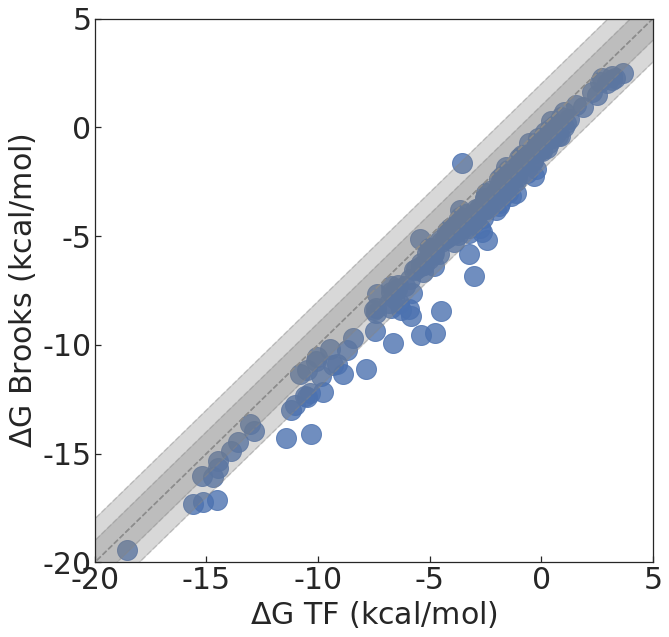

In [12]:
fig, axs = plt.subplots(1,1, figsize=(10, 10))

x = data["dG (TF)"]
brooks = data["dG (Brooks)"]

axs.scatter(x,brooks, alpha = 0.8, color = "C0")

plotting_grey_area(0, one_plot=True)
axs.set_xlim([-20,5])
axs.set_ylim([-20,5])
axs.set_xlabel("$\Delta$G TF (kcal/mol)")
axs.set_ylabel("$\Delta$G Brooks (kcal/mol)")  
plt.legend(frameon=False)

In [13]:
my_cols = ["id","iupac", "group1", "group2", "group3", "group4", "group5", "group6", "group7"]
groups = pd.read_csv("data/groups.txt", delimiter=";", names = my_cols, skiprows= 1)
groups["group1"] = groups["group1"].str.strip()
groups["iupac"] = groups["iupac"].str.strip()

In [14]:
groups.loc[:,"exp"] = np.nan
groups.loc[:,"exp TF"] = np.nan
groups.loc[:,"calc GAFF"] = np.nan
groups.loc[:,"calc TF"] = np.nan

for index, row in groups.iterrows():
    for index2,row2 in data.iterrows():
      if row["id"] == row2["# compound id (and file prefix)"]:
        groups.loc[index, "calc GAFF"] = row2[" Mobley group calculated value (GAFF) (kcal/mol)"]
        groups.loc[index, "exp"] = row2[" experimental value (kcal/mol)"]

        if not np.isnan(row2["dG (TF)"]):
          groups.loc[index, "calc TF"] = row2["dG (TF)"]
          groups.loc[index, "exp TF"] = row2[" experimental value (kcal/mol)"]

comb = groups.groupby("group1", as_index = False)[["exp","calc GAFF"]].agg(lambda x: list(x))
comb = comb.dropna(axis=0)

comb_tf = groups.groupby("group1", as_index = False)[["exp TF","calc TF"]].agg(lambda x: list(x))
comb_tf = comb_tf.dropna(axis=0)

In [15]:
def calculate_stats_per_row(x,y):
    rmse = np.sqrt(mean_squared_error(x,y))
    mae = mean_absolute_error(x,y)
    r = scipy.stats.pearsonr(x,y)[0]

    return rmse, mae, r

In [16]:
def create_df(df,x_name, y_name):
  df.loc[:,"rmse"] = np.nan
  df.loc[:,"mae"] = np.nan
  df.loc[:,"r"] = np.nan
  df.loc[:,"number"] = np.nan

  for index,row in df.iterrows():
      x= row[x_name]
      y = row[y_name]
      x = [a for a in x if str(a) != 'nan']
      y = [a for a in y if str(a) != 'nan']
      if len(x) == len(y) and len(x) > 10:
          rmse, mae, r = calculate_stats_per_row(x,y)
          df.loc[index, "rmse"] = rmse
          df.loc[index, "mae"] = mae
          df.loc[index, "r"] = r
          df.loc[index, "number"] = len(x)

  return df 

comb = create_df(comb,"exp", "calc GAFF")
comb_tf = create_df(comb_tf,"exp TF", "calc TF")


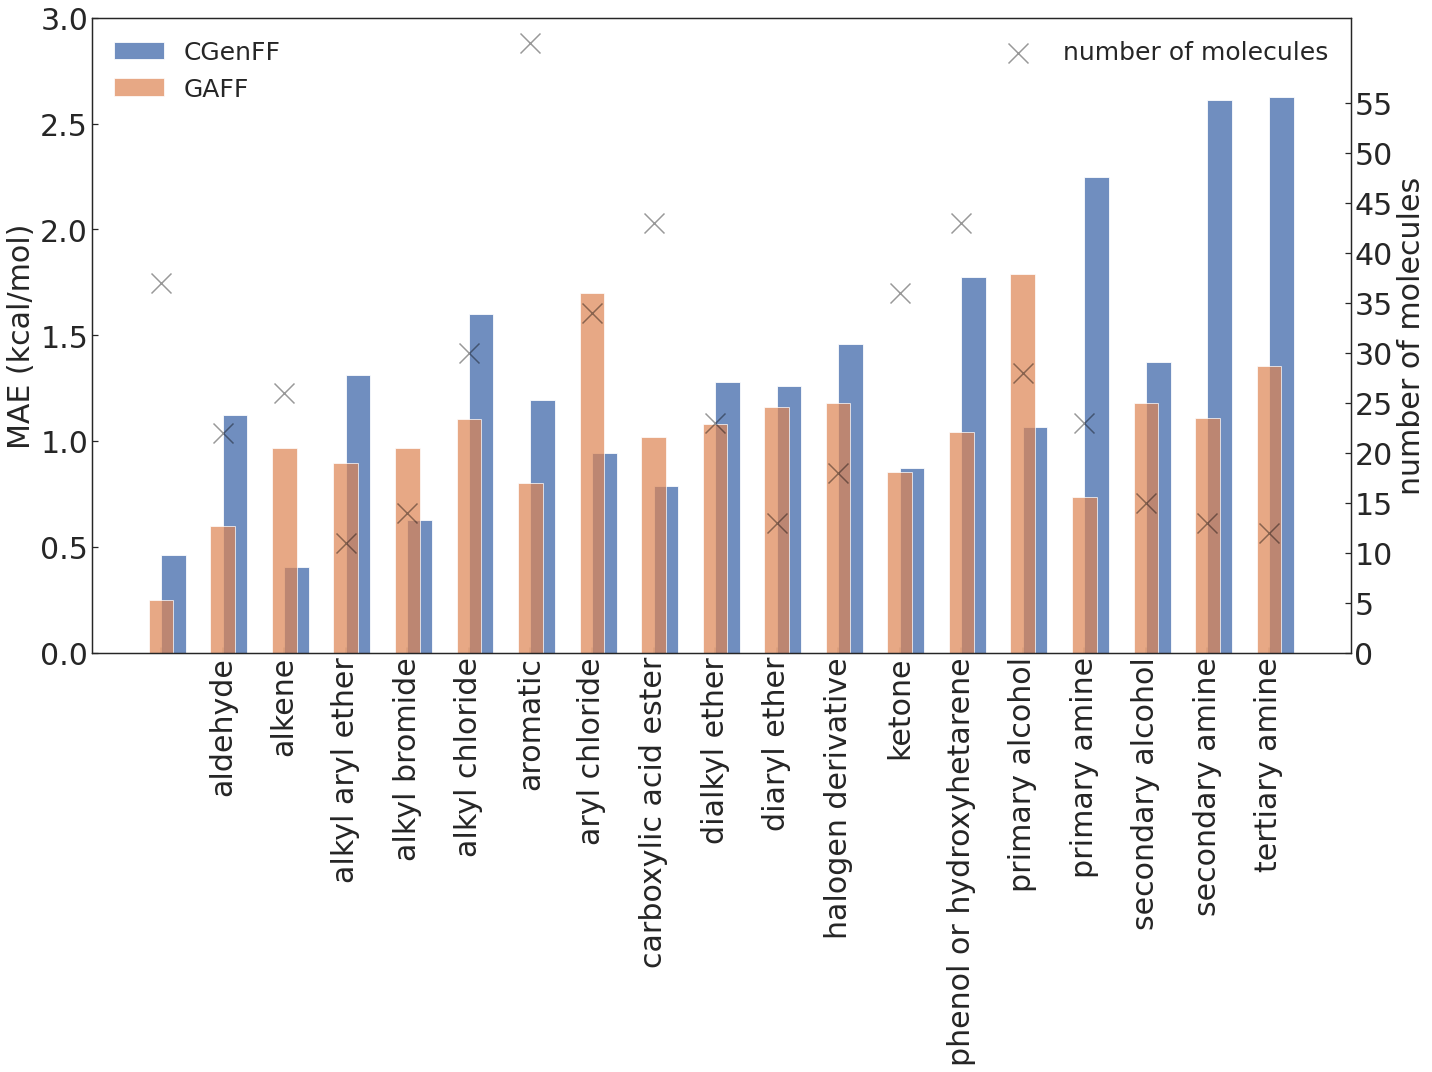

In [17]:
# sns.set_theme(style='white', rc={'figure.figsize': (10,10),'axes.unicode_minus': False,'axes.labelsize': 15.0, 'font.size': 40, 'legend.fontsize': 15, 'lines.markersize': 10,'xtick.labelsize': 15,'ytick.labelsize': 15, 'ytick.direction': "in"})

fig, ax1 = plt.subplots(figsize=(20, 15))
fig.autofmt_xdate(rotation=90, ha = "center")

comb_tf = comb_tf.dropna(axis=0)
ax1.bar(comb_tf["group1"],comb_tf["mae"], alpha = 0.8 ,align = "edge", width = 0.4 , label="CGenFF")

comb = comb.dropna(axis=0) # remove all nan
ax1.bar(comb["group1"],comb["mae"], alpha = 0.7 ,width = 0.4, label = "GAFF")

# Second axis
ax2 = ax1.twinx()
ax2.scatter(comb["group1"],comb["number"], color = "black" ,label ="number of molecules", marker="x", alpha = 0.4)
ax2.set_ylabel("number of molecules")

ax1.legend(frameon=False, loc ="upper left")
ax2.legend(frameon=False)

ax2.set_yticks(np.arange(0,60,5))
ax1.set_yticks(np.arange(0,3.5,0.5))
ax1.set_ylabel("MAE (kcal/mol)")
plt.tight_layout()
# plt.savefig("histogram.png",dpi = 500)

In [25]:
groups.loc[:,"GAFF"] = np.nan
groups.loc[:,"CGenFF"] = np.nan

for index, row in groups.iterrows():
    for index2,row2 in data.iterrows():
      if row["id"] == row2["# compound id (and file prefix)"]:
        groups.loc[index, "GAFF"] = np.abs(row2[" Mobley group calculated value (GAFF) (kcal/mol)"] -row2[" experimental value (kcal/mol)"])

        if not np.isnan(row2["dG (TF)"]):
          groups.loc[index, "CGenFF"] = np.abs(row2["dG (TF)"]-row2[" experimental value (kcal/mol)"])

comb = groups.groupby("group1", as_index = False)[["exp","calc GAFF"]].agg(lambda x: list(x))
comb = comb.dropna(axis=0)

comb_tf = groups.groupby("group1", as_index = False)[["exp TF","calc TF"]].agg(lambda x: list(x))
comb_tf = comb_tf.dropna(axis=0)

groups_calc = groups[["GAFF", "CGenFF"]]
melted = groups_calc.reset_index().melt(id_vars='index', var_name='Force Field', value_name='MAE')
melted = pd.merge(melted, groups, left_on='index', right_index=True)
#melted = melted.reset_index()
counts = melted['group1'].value_counts()
melted = melted[melted['group1'].isin(counts.index[counts >= 20])]

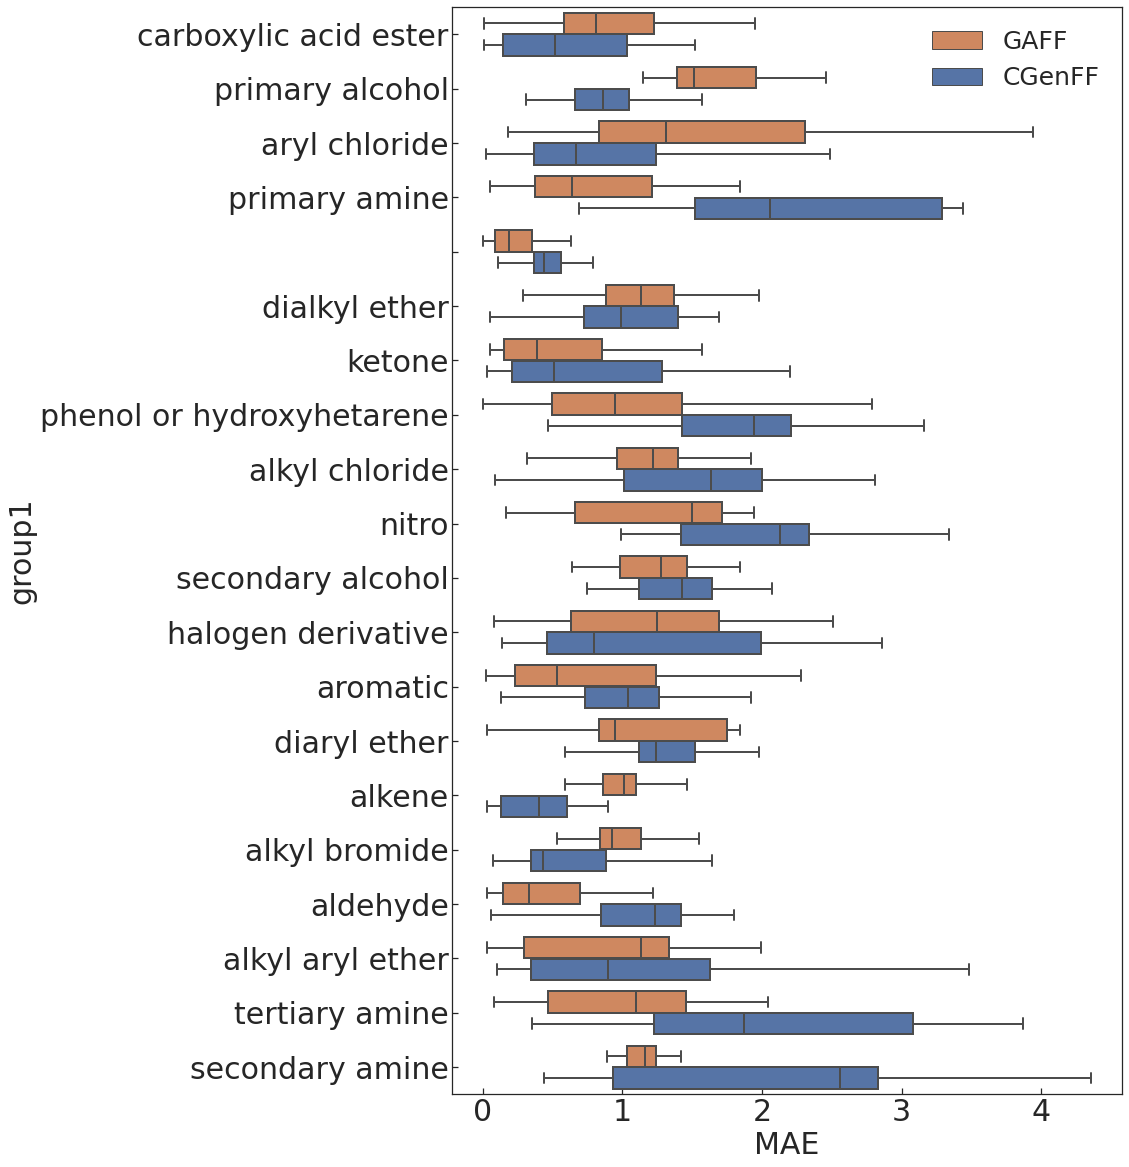

In [93]:
fig, ax1 = plt.subplots(figsize=(12, 20))
# fig.autofmt_xdate(rotation=90, ha = "center")

flierprops = dict(marker='o', markerfacecolor='r', markersize=12,
                  linestyle='none', markeredgecolor='g')
sns.boxplot(data=melted,y="group1",x="MAE",hue="Force Field",saturation=0.8,linewidth=2,palette={"GAFF": "C1", "CGenFF": "C0"},fliersize=12, orient="h", showfliers = False)
plt.legend(frameon=False)

In [18]:
try:
    subset = pd.read_csv("https://raw.githubusercontent.com/JohannesKarwou/notebooks/main/data/subset.csv?token=GHSAT0AAAAAAB5HV5NPZUFRMJO24Q3LZP32Y74YNSA",header = 1)
except:
    subset = pd.read_csv("data/subset.csv",header=1)

In [19]:
subset = subset[0:19]

def reduce_df(df,column1,column2):
    for index,row in df.iterrows():
        if np.isnan(row[column1]):
            df = df.drop(index, axis=0)
    for index,row in df.iterrows():
        if np.isnan(row[column2]):
            df = df.drop(index, axis=0)
    return df


TypeError: 'AxesSubplot' object does not support item assignment

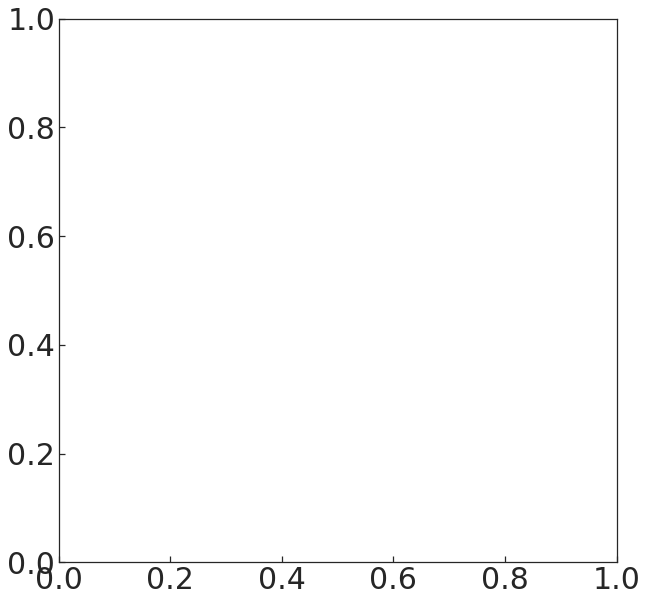

In [20]:
# fig, axs = plt.subplots(1,2, figsize=(20, 10), sharey=True) #,sharey=True, sharex=True
# fig.subplots_adjust(hspace = 0.2, wspace=0.1)
# axs = axs.ravel()

fig, axs[0] = plt.subplots(figsize=(10, 10))
fig, axs[1] = plt.subplots(figsize=(10, 10))

i = 0
plotting_grey_area(i)
axs[i].set_xlim([-7.5,3.5])
axs[i].set_ylim([-7.5,3.5])
axs[i].set_xlabel("$\Delta$G TF (kcal/mol)")
axs[i].set_ylabel("$\Delta$G reference calculations (kcal/mol)")  

x = "ref dG (TF)"
y = "ref_stefan"

print("##################")
print("Wieder/Stefan vs TF")
df = reduce_df(subset,x, y)
rmse, mae, r, _ , _= calculate_statistics(df[x],df[y])

axs[i].scatter(subset[x],subset[y], color ="C2", label = "Wieder et. al.", alpha = 0.8)
text = f'RMSE: {rmse}\nMAE: {mae}\nR: {r}'
axs[i].text(0,-4.8, text , fontsize=27, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'C2', 'ec': 'C2', 'alpha': 0.4})

y = "ref_fleck"

print("##################")
print("Fleck vs TF")
df2 = reduce_df(subset,x, y)
rmse, mae, r, _ , _ = calculate_statistics(df2[x],df2[y])

axs[i].scatter(subset[x],subset[y],marker ="d", color ="C3", label = "Fleck et. al.", alpha = 0.8)
text = f'RMSE: {rmse}\nMAE: {mae}\nR: {r}'
axs[i].text(0,-7, text , fontsize=27, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'C3', 'ec': 'C3', 'alpha': 0.4})

axs[i].legend(frameon=False)

plt.savefig("comparison_charmm_pure.png", dpi = 500)
plt.close()

i =1

plotting_grey_area(i)
axs[i].set_xlim([-7.5,3.5])
axs[i].set_ylim([-7.5,3.5])
axs[i].set_xlabel("$\Delta$G TF (kcal/mol)")
axs[i].set_ylabel("$\Delta$G reference calculations (kcal/mol)")  

x = "cor dG (TF)"
y = "cor_stefan"

print("##################")
print("Wieder/Stefan vs TF")
df3 = reduce_df(subset,x, y)
rmse, mae, r, _ , _ = calculate_statistics(df3[x],df3[y])

axs[i].scatter(subset[x],subset[y], color ="C2", label = "Wieder et. al.", alpha = 0.8)
text = f'RMSE: {rmse}\nMAE: {mae}\nR: {r}'
axs[i].text(0,-4.8, text , fontsize=27, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'C2', 'ec': 'C2', 'alpha': 0.4})

y = "cor_fleck"

print("##################")
print("Fleck vs TF")
df4 = reduce_df(subset,x, y)
rmse, mae, r, _ , _ = calculate_statistics(df4[x],df4[y])

axs[i].scatter(subset[x],subset[y],marker ="d", color ="C3", label = "Fleck et. al.", alpha = 0.8)
text = f'RMSE: {rmse}\nMAE: {mae}\nR: {r}'
axs[i].text(0,-7, text , fontsize=27, bbox ={'boxstyle': 'square', 'fill': True, 'fc': 'C3', 'ec': 'C3', 'alpha': 0.4})

axs[i].legend(frameon=False)

plt.savefig("comparison_charmm_cleaned.png", dpi = 500)
